#**Projet 07 - Implémentez un modèle de scoring**

PLAN :

**I. Importation des librairies et chargement des données**

**II. Traitements divers**
1. Appliquer une réduction de dimension
2. Imputation
3. Suppression des colonnes non utiles

**III. Baseline**
1. Sépération X et Y
2. Dummy classifier

**IV. Modélisation**
1. Méthode pour éviter le déséquilibre des classes
2. Optimisation des hyper paramètres
3. Execution des modèles (Random Forest,  XGBoost, LightGBM, LightGBM bank)
4. Comparaison et sélection du meilleur modèle

**V. Importance des features**

**VI. Conclusion**



##**I. Importation des librairies et chargement des données**

In [1]:
#Importer les librairies utiles à notre analyse

#Création de dataframe
import pandas as pd

#Création de calculs complexes 
import numpy as np

# Tracer des graphiques et visualiser des données
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import seaborn as sns

# google drive
from google.colab import drive

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sklearn processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Sklearn classification algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Sklearn classification model evaluation functions
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

!pip install shap 
import shap
! pip install lime
import lime
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["ok","default"])

from sklearn.dummy import DummyClassifier

from sklearn.utils import resample

import pickle

import time
%matplotlib inline
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Chargement des données
app_enc = pd.read_csv('/content/drive/MyDrive/app_enc.csv')

In [3]:
app_enc.shape

(356251, 798)

##**II. Traitements divers**

###**1. Réduction de dimension**

In [4]:
app_enc = app_enc.sample(10000)
pca = PCA()
scaler_text = StandardScaler()
pca.fit(scaler_text.fit_transform(app_enc.fillna(0).replace([-np.inf, np.inf],0)))

PCA()

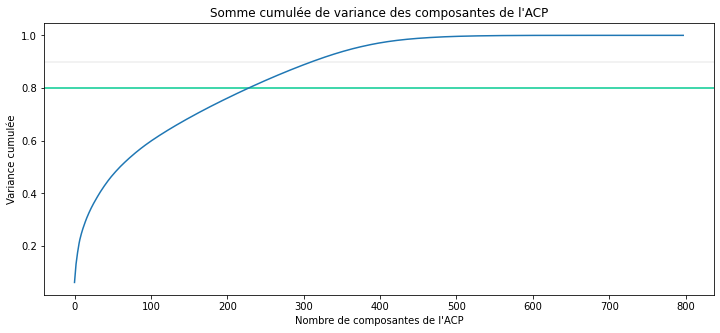

In [5]:
plt.figure(figsize=(12,5))
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.axhline(y=0.8, color='#02CA91', linestyle='-')
plt.axhline(y=0.9, color='#efefef', linestyle='-')
plt.plot(list(range(app_enc.shape[1])),
         np.cumsum(pca.explained_variance_ratio_))

Sur les 798 variables sélectionnées, nous constatons qu'environ 250 peuvent couvrir une inertie de 80%.

In [6]:
app_enc.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,...,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
14457,14457,116868,0.0,1,0,0,1,85500.0,86598.0,9315.0,76500.0,0.007120,-14675,-6875.0,-5438.0,-4647,NaN,1,1,1,1,1,0,2.0,2,2,9,0,0,0,0,1,1,NaN,0.262258,0.484851,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300402,300406,448032,0.0,0,1,0,2,315000.0,270000.0,13500.0,270000.0,0.072508,-16051,-262.0,-252.0,-4253,7.0,1,1,0,1,0,0,4.0,1,1,14,0,1,1,0,0,0,0.657884,0.736180,0.614414,0.0619,0.0,0.9732,0.6328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92399,92402,207294,0.0,0,0,0,1,270000.0,1515415.5,41800.5,1354500.0,0.018029,-8951,-1042.0,-3398.0,-1604,NaN,1,1,0,1,0,0,3.0,3,3,7,0,0,0,0,0,0,0.149891,0.311802,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87978,87981,202137,0.0,0,1,0,0,405000.0,900000.0,41836.5,900000.0,0.014520,-17991,-683.0,-6370.0,-1549,4.0,1,1,0,1,0,0,2.0,2,2,6,0,0,0,0,0,0,NaN,0.520202,0.475850,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106344,106347,223380,1.0,1,0,1,2,135000.0,180000.0,9000.0,180000.0,0.018029,-13272,-1667.0,-61.0,-1048,NaN,1,1,0,1,0,0,4.0,3,3,12,0,0,0,0,0,0,0.260511,0.453580,0.479449,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###**2. Imputation**

Pourcentage de Nan dans le dataset

In [7]:
app_enc.isna().sum().sum()/app_enc.size

0.25381804511278194

In [8]:
column_with_nan = app_enc.columns[app_enc.isnull().any()]

Suppression des colonnes avec plus de 70% de Nan

In [9]:
for column in column_with_nan:
     if app_enc[column].isnull().sum()*100.0/app_enc.shape[0] > 70:
             app_enc.drop(column,1, inplace=True)
 

In [10]:
app_enc.shape

(10000, 643)

In [11]:
app_enc.isna().sum().sum()/app_enc.size

0.13771788491446346

Gestion des infinis et des Nan

In [12]:
# Remplacer les chiffres inifis par nan, puis remplacer par 0
app_enc.replace([np.inf, -np.inf], np.nan, inplace=True)
app_enc.fillna(0, inplace=True)

In [13]:
# Suppression des colonnes non utiles au projet
app_enc.drop(columns=['index'],inplace=True)

In [14]:
app_enc.isna().sum().sum()/app_enc.size

0.0

##**III. Baseline**

###**1. Séparation X et Y**

In [15]:
# Découpage originale
sample = app_enc#.sample(100000)
#sans nan
app_enc_train = sample[~app_enc["TARGET"].isnull()]

In [16]:
app_enc_train.shape

(10000, 642)

In [17]:
exportsample = app_enc_train.iloc[:5000]
exportsample.to_csv('/content/drive/MyDrive/app_sample.csv', index=False)
exportsample.to_csv('/content/drive/MyDrive/app_sample_index.csv', index=True)

In [18]:
#avec nan
# app_enc_test = sample[app_enc["TARGET"].isnull()]
# export_test = app_enc_test.drop(columns="TARGET")

In [19]:
y = app_enc_train["TARGET"].copy()
X = app_enc_train.copy().drop(columns="TARGET")

In [20]:
del app_enc
del app_enc_train
gc.collect()

292

In [21]:
# Standardisation des colonnes numériques

#Identification des colonnes numériques
numerical_columns = X.select_dtypes(['int32','float64', "int64"]).columns
numerical_columns = numerical_columns.drop("SK_ID_CURR")

#Normalisation avec Minmax
mm = MinMaxScaler(feature_range = (0, 1))
X[numerical_columns] = mm.fit_transform(X[numerical_columns])

In [22]:
X[:5000].to_csv('/content/drive/MyDrive/app_sample_normalized.csv', index=True)
X.drop(columns=['SK_ID_CURR'],inplace=True)

In [23]:
exportsample.shape

(5000, 642)

In [24]:
X.shape

(10000, 640)

###**2. Tester un modèle Dummy Classifier sur les données**

1 : défaut de paiement / 0 : bon payeur
- Faux positifs : identifé mauvais payeur alors que bon payeur
- Faux négatifs : identifié bon payeur alors que mauvais payeur
- Vrais positifs : vrai mauvais payeur identifié
- Vrais négatifs : vrai bon payeur identifié

Scoring sélectionnés :
- **Precision**: la proportion de prédictions correctes parmi les points que l’on a prédits positifs TP/ TP+FP. C’est la capacité de notre modèle à ne déclencher d’alarme que pour un vrai incendie. 

- **Recall** : est le taux de vrais positifs, c’est à dire la proportion de positifs que l’on a correctement identifiés.  TP/ TP+FN. C’est la capacité de notre modèle à détecter tous les incendies.

- **F-mesure**: Pour évaluer un compromis entre rappel et précision, on peut calculer la "F-mesure", qui est leur moyenne harmonique.

- **AUC**  : The AUC provides a numerical measure for comparing ROC curves. A value of 1 indicates a model that perfectly separates the classes.

- **Acuracy** :  il indique le pourcentage de bonnes prédictions : à max 



In [25]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

def predict_and_outputscore(model, model_name, X_test, y_test, threshold=0.5):
  # predict_proba va nous retourner des probabilités
  y_res = model.predict_proba(X_test)
  # transform_with_threshold va transformer les probabilités de y_res en 0 (pas de défaut) ou 1 (défaut de paiement) 
  # en appliquant le seuil de prédiction de défaut de paiement à la valeur threshold
  y_predict = transform_with_threshold(y_res, threshold)
  roc_auc = roc_auc_score(y_test, y_predict)
  f1 = f1_score(y_test, y_predict)
  precision = precision_score(y_test, y_predict)
  recall = recall_score(y_test, y_predict)
  confusion = confusion_matrix(y_test, y_predict)
  accuracy = accuracy_score (y_test, y_predict)

  print(model_name + " f1: " + str(f1))
  print(model_name + " roc_auc: " + str(roc_auc))
  print(model_name + " precision: " + str(precision))
  print(model_name + " recall: " + str(recall))
  print(model_name + " confusion: " + str(confusion))
  print(model_name + " accuracy: " + str(accuracy))

  return y_res, roc_auc, f1, precision, recall, confusion, accuracy

In [26]:
# transformer le vecteur de probabilité en un vecteur de prédiction
# prend un vecteur y_proba qui contient des valeurs de type ([0.1 0.9], [0.2 0.8]) pour les transformer en un vecteur de prediction de type (1 0) en appliquant la valeur de seuil sur la probabilité de défaut de paiment
# c-à-d sur 0.9 et 0.8 par ex.
def transform_with_threshold(y_proba, threshold):
  y_predict = (pd.DataFrame(y_proba)[1] > threshold).astype(int).values
  return y_predict

In [27]:
modeles_dict = {}

In [28]:
# baseline avec dummy classifier 
# choisir most_frequent, la classe la plus fréquente à 92% (classe majoritaire) acuracy pas la meilleure metric
X_train, X_test, y_train, y_test = \
                        train_test_split(X,
                                         y,
                                         test_size = 0.1,
                                         random_state = 42
                                        )
                        
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)

(y_res, roc_auc, f1, precision, recall, confusion, accuracy) = predict_and_outputscore(dummy_classifier, "Dummy Classifier", X_test, y_test)
modeles_dict["Dummy Classifier"] = (roc_auc, f1, precision, recall, accuracy)
# dummy_classifier.score(X_test, y_res)

Dummy Classifier f1: 0.0
Dummy Classifier roc_auc: 0.5
Dummy Classifier precision: 0.0
Dummy Classifier recall: 0.0
Dummy Classifier confusion: [[925   0]
 [ 75   0]]
Dummy Classifier accuracy: 0.925


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [29]:
X_train.shape

(9000, 640)

In [30]:
X_test.shape

(1000, 640)

**Limite de l'accuracy** 

Selon le score de l'accuracy, le modèle prédirait à 91%. Or cela peut s'expliquer par le déséquilibre des classes.

In [31]:
# Define a function to plot the ROC/AUC
def plotRocAuc(model, X, y):
    
    probabilities = model.predict_proba(X)
    probabilities = probabilities[:, 1]  # keep probabilities for first class only
        
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y, probabilities)    
    
    # Plot the "dumb model" line
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    # Plot the model line
    plt.plot(fpr, tpr, marker='.')
    plt.text(0.75, 0.25, "AUC: " + str(round(roc_auc_score(y, probabilities),2)))
    
    # show the plot
    plt.show()

##**IV. Modélisation**

###**1. Techniques pour éviter le déséquilibre des classes**

Mettre en place plusieurs méthodes et les comparer pour contrecarrer le problème d'équilibre des classes et tester avec le modèle déjà existant, en utilisant les métriques: f1-score, precision, recall, confusion matrix et AUC score.
- **SMOTE**

- **Resampling**

- **Intrinsèque** jouer sur les paramètres Random Forest et LigtGBM

####**1.1 Resampling**

Le resampling consiste à retirer des échantillons de la classe majoritaire (sous-échantillonnage) et/ou à ajouter plus d'exemples de la classe minoritaire (sur-échantillonnage).

In [32]:
#https://openclassrooms.com/fr/courses/6401081-improve-the-performance-of-a-machine-learning-model/6519011-evaluate-the-performance-of-a-classification-model

def resample_for_bank(x_toresample, y_toresample):
  Xy_dataset = pd.concat([x_toresample, y_toresample], axis=1)
  Xy_dataset_nodefault = Xy_dataset[Xy_dataset.TARGET==0]
  Xy_dataset_default = Xy_dataset[Xy_dataset.TARGET==1]
  Xy_dataset_nodefault_count = Xy_dataset_nodefault.shape[0]
  print("no default " + str(Xy_dataset_nodefault_count))
  Xy_dataset_default_count = Xy_dataset_default.shape[0]
  print("default " + str(Xy_dataset_default_count))
  Xy_dataset_default_oversampled = resample(Xy_dataset_default, replace=True, n_samples=Xy_dataset_nodefault_count)
  combined = pd.concat([Xy_dataset_default_oversampled, Xy_dataset_nodefault])
  y_resampled = combined.TARGET
  X_resampled = combined.drop('TARGET', axis=1)
  return X_resampled, y_resampled

In [33]:
X_resampled, y_resampled = resample_for_bank(X_train, y_train)

no default 8358
default 642


In [34]:
# nombre de samples positifs
(y_resampled == 1).sum()

8358

In [35]:
# nombre de samples négatifs
(y_resampled == 0).sum()

8358

####**1. 2 SMOTE**

Synthetic Minority Oversampling Technique fonctionne en choisissant au hasard un point de la classe minoritaire et en calculant les k plus proches voisins pour ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.

In [37]:
# https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

smote = SMOTE()
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train, y_train)

# print('Original dataset shape', Counter(y))
# print('Resample dataset shape', Counter(y_ros))

In [38]:
# nombre de samples positifs
(y_smote == 1).sum()

8358

In [39]:
# nombre de samples négatifs
(y_smote == 0).sum()

8358

### **2. Optimisation pour le choix des hyperparamètres**

####**2. 1 Choix des modèles**

- Random Forest 
- XG Boost 
- LightGBM 

ETAPES :
- faire StratifiesKFold
- Faire cross Validation
- Varier les valeurs des paramètres avec Hyperopt
- Afficher les best paramètres
- Entrainement des modèles sur tout le jeu de données


####**2. 2 Choix des hyperparamètres**

Pour utiliser Hyperopt, nous devons spécifier quatre éléments clés pour notre modèle :
1. Fonction objectif | Cela devrait renvoyer la valeur que nous voulons minimiser pendant le calcul. Dans notre cas, il s'agit de la fonction 'accuracy_score'.
2. Espace de recherche | Cela définit la plage de valeurs qu'un hyperparamètre donné peut prendre. Il peut s'agir d'entiers, de flottants ou de chaînes comme nous le verrons plus loin dans l'article.
3. Algorithme de réglage | Dans Hyperopt, il existe deux principaux algorithmes de recherche d'hyperparamètres : la recherche aléatoire et les estimateurs d'arbre de Parzen (bayésien). Dans cet exemple, nous utiliserons ce dernier car il est connu pour produire les meilleurs résultats.
4. Évaluations | Cela fait référence au nombre d'instances d'hyperparamètres différentes sur lesquelles entraîner le modèle. Il est recommandé qu'il soit compris entre 10 et 30 fois le nombre d'hyperparamètres définis dans l'espace de recherche pour optimiser les performances et le temps de calcul.


**Création d'une métrique**

La métrique normalized_bank_cost consiste à calculer un score calculé pour l'ensemble des clients

Pour cela nous avons fixé un poids arbitraire pour chacune des prédictions relativement à leurs valeurs réelles.

Les valeurs des poids sont les suivantes :

L'objectif est de minimiser une fonction de coût
- fn_value (mauvais payeur identifié bon payeur) = 10
- tp_value = 0
- tn_value = 0
- fp_value (bon payeur identifié comme mauvais payeur : manque à gagner) = 1

In [40]:
# on met des paramètres pour minimiser les faux 
def normalized_bank_cost(y, y_pred, fn_val=10, fp_val=1, auc_val=0):
  #AUC_val = 0
    confusion = confusion_matrix(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    # true negatives : des bon payeurs correctement identifiés
    tn = confusion[0, 0]
    # false negatives : des mauvais payeurs identifiés en bon payeur
    fn = confusion[1, 0]
    # false positives : bon payeurs identifiés comme mauvais
    fp = confusion[0, 1]
    # true positives : mauvais payeurs correctement identifiés
    tp = confusion[1, 1]

    return fn*fn_val + fp*fp_val + auc*auc_val

**Fonction Hyperopt**

In [41]:
# https://ichi.pro/fr/optimisez-votre-reglage-d-hyperparametres-avec-hyperopt-147426684149429
# Utiliser Hyperopt

In [42]:
# read in hyperopt values
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

In [52]:
# set the hyperparam tuning algorithm
algorithm=tpe.suggest

# une fonction qui créé une fonction utilisable par hyperopt
# méthode qui va utiliser le folding pour entrainer le modèle pour chaque fold 
# ... et prendre la moyenne du score de chacun des fold entrainé
# search space : utilisé pour l'optimisation des paramètres (espace d'intervalle)

# x_smote, y_smote
def optimize_function(model_alg, folding, model_name, scoring, intr=None):
  def optimize(search_space):
    model = model_alg(**search_space["params"])
    smote = SMOTE()
    scores = []
    for train_index, test_index in folding.split(X_train, y_train):
      x_training_set, y_training_set = X_train.iloc[train_index], y_train.iloc[train_index]
      x_test_set, y_test_set = X_train.iloc[test_index], y_train.iloc[test_index]
      if(search_space["sampling"] == "smote"):
        x_train_iter, y_train_iter = smote.fit_resample(x_training_set, y_training_set)
      else:
        x_train_iter, y_train_iter = resample_for_bank(x_training_set, y_training_set)
      model.fit(x_train_iter, y_train_iter)
      y_proba = model.predict_proba(x_test_set)
      y_predict = (pd.DataFrame(y_proba)[1] > search_space["threshold"]).astype(int).values
      scores.append(scoring(y_test_set, y_predict))
    
    return {'loss': np.mean(scores), 'status': STATUS_OK}
    
  return optimize

In [44]:
#Folding
skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)
kf = KFold(n_splits= 5, shuffle=True, random_state=1001)

###**3. Execution et optimisation des différents modèles**

In [45]:
def inverted_f1_score(*args):
  return -1 * f1_score(*args)
def inverted_roc_auc_score(*args):
  return -1 * roc_auc_score(*args)

In [53]:
random_forest_optimize = optimize_function(RandomForestClassifier, skf, "RandomForestClassifier", inverted_roc_auc_score)
random_forest_optimize_bank = optimize_function(RandomForestClassifier, skf, "RandomForestClassifier", normalized_bank_cost)
lgbm_optimize = optimize_function(LGBMClassifier, skf, "LGBMClassifier", inverted_roc_auc_score)
lgbm_optimize_bank = optimize_function(LGBMClassifier, skf, "LGBMClassifier", normalized_bank_cost)
xgb_optimize = optimize_function(XGBClassifier, skf, "XGBClassifier", inverted_roc_auc_score)

####**3. 1 Random Forest**

In [74]:
# sample_weight in fit
search_space_rf = {
    'params': 
    {
      'n_estimators':hp.randint('n_estimators',50)+1,            
      'max_depth': hp.randint('max_depth',100)+1,
      'min_samples_split':hp.uniform('min_samples_split',0,1),
      'min_samples_leaf':hp.randint('min_samples_leaf',10)+1,  
      'criterion':hp.choice('criterion',['gini','entropy']),    
      'max_features':hp.choice('max_features',['sqrt', 'log2'])
    },
    'threshold': hp.uniform('threshold',0.4,0.6),
    'sampling':hp.choice('sampling',['resampling','smote']),
  # "sample_intra_param": {"sample_weight":[]}
}

In [75]:
# execution du modèle
best_params_rf = fmin(fn=random_forest_optimize, space=search_space_rf, algo=algorithm, max_evals=10)
#best_params_rf_bank = fmin(fn=random_forest_optimize_bank, space=search_space_rf, algo=algorithm, max_evals=10)

no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
100%|██████████| 10/

In [76]:
# Meilleurs paramètres Random Forest 
best_params_rf_eval = space_eval(search_space_rf, best_params_rf)
best_params_rf_eval

{'params': {'criterion': 'entropy',
  'max_depth': 55,
  'max_features': 'sqrt',
  'min_samples_leaf': 9,
  'min_samples_split': 0.07482541125597109,
  'n_estimators': 29},
 'sampling': 'resampling',
 'threshold': 0.4255698752135477}

In [ ]:
# Meilleurs paramètres Random Forest avec la metrique bank
# best_params_rf_bank_eval = space_eval(search_space_rf, best_params_rf_bank)
# best_params_rf_bank_eval

In [77]:
#Obtenir le temps d'execution
start = time.time()

if(best_params_rf_eval["sampling"] == "resampling"):
  x_fit = X_resampled
  y_fit = y_resampled
else:
  x_fit = x_smote
  y_fit = y_smote

rf_model = RandomForestClassifier(**best_params_rf_eval["params"])
rf_model.fit(x_fit, y_fit)
trainend = time.time()
print("Temps d'entrainement: " + str(trainend - start))
(y_res_rf, roc_auc_rf, f1_rf, precision_rf, recall_rf, confusion_rf, accuracy_rf) = predict_and_outputscore(rf_model, "RandomForestClassifier", X_test, y_test, best_params_rf_eval["threshold"])
modeles_dict["RandomForestClassifier"] = (roc_auc_rf, f1_rf, precision_rf, recall_rf, accuracy_rf)

confusion_rf = confusion_rf.astype(np.float)
confusion_rf[0] = (confusion_rf[0]/confusion_rf[0].sum())
confusion_rf[1] = (confusion_rf[1]/confusion_rf[1].sum())
print("Temps total: " + str(time.time() - start))
print("Temps de prédiction: " + str(time.time() - trainend))

Temps d'entrainement: 1.7676222324371338
RandomForestClassifier f1: 0.18694885361552027
RandomForestClassifier roc_auc: 0.616036036036036
RandomForestClassifier precision: 0.10772357723577236
RandomForestClassifier recall: 0.7066666666666667
RandomForestClassifier confusion: [[486 439]
 [ 22  53]]
RandomForestClassifier accuracy: 0.539
Temps total: 1.797034502029419
Temps de prédiction: 0.029558658599853516


Text(0.5, 1.0, 'Confusion matrix')

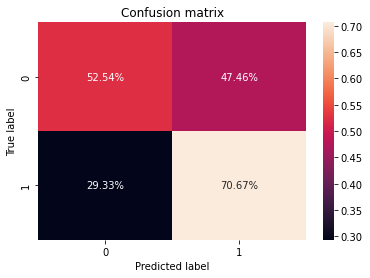

In [79]:
# matrice de confusion

sns.heatmap(confusion_rf, annot=True, fmt='.2%', cbar=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')


Explication : 
- Env 70% des défauts de paiement ont été correctement prédits / 29% des mauvais payeurs ont été identifiés comme bon payeurs
- 52 % de non défaut de paiement ont été correctement prédits / 48 % des bon payeurs ont été qualifiés de défaut de paiement 

####**3. 2 XGBoost**

In [87]:
# Number_of_positives = (y_test == 1).sum()
# Number_of_negatives = (y_test == 0).sum()
# scale_pos_weight = Number_of_negatives/Number_of_positives)
 # "sample_intra_param": {"sample_weight":[]}

search_space_xgboost = {
    'params': 
    {
      'learning_rate': hp.uniform('learning_rate',0,1), 
      'max_depth': hp.randint('max_depth',5)+1,
      'n_estimators': hp.randint('n_estimators',1000)+1,
      'num_leaves' : hp.randint('num_leaves',10)+30,
      'colsample_bytree': hp.uniform('colsample_bytree',0,1), 
      'subsample' : hp.uniform('subsample',0,1),
      'reg_alpha' : hp.uniform('reg_alpha',0,1),  
      'reg_lambda' : hp.uniform('reg_lambda',0,1),  
      'min_split_gain' : hp.uniform('min_split_gain',0,1), 
      'min_child_weight' : hp.uniform('min_child_weight',30,40), 
    },
    'threshold': hp.uniform('threshold',0.01,0.6),
    'sampling':hp.choice('sampling',['resampling','smote']),
    # "sample_intra_param": {"scale_pos_weight":Number_of_negatives/Number_of_positives}
}

In [88]:
# recherche des meilleurs paramètres

best_params_xg = fmin(fn=xgb_optimize, space=search_space_xgboost, algo=algorithm, max_evals=10)

no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
100%|██████████| 10/10 [30:03<00:00, 180.32s/it, best loss: -0.6577763394622074]


In [89]:
# Meilleurs paramètres XGBoost 
best_params_xg_eval = space_eval(search_space_xgboost, best_params_xg)
best_params_xg_eval
# 'threshold': 0.4761934733866644 <= le meilleur seuil de qualification en défaut de paiement est à partir de 0.47

{'params': {'colsample_bytree': 0.5213446448383556,
  'learning_rate': 0.521130699594623,
  'max_depth': 1,
  'min_child_weight': 39.89592724860764,
  'min_split_gain': 0.35847943197597076,
  'n_estimators': 533,
  'num_leaves': 39,
  'reg_alpha': 0.18209414133839164,
  'reg_lambda': 0.6126064202607834,
  'subsample': 0.2537778289354816},
 'sampling': 'resampling',
 'threshold': 0.32130337667675263}

In [90]:
start = time.time()

if(best_params_xg_eval["sampling"] == "resampling"):
  x_fit = X_resampled
  y_fit = y_resampled
else:
  x_fit = x_smote
  y_fit = y_smote


XGBC_model = XGBClassifier(**best_params_xg_eval["params"])
XGBC_model.fit(x_fit, y_fit)
trainend = time.time()
(y_res_xg, roc_auc_xg, f1_xg, precision_xg, recall_xg, confusion_xg, accuracy_xg) = predict_and_outputscore(XGBC_model, "XGBCClassifier", X_test, y_test, best_params_xg_eval["threshold"])
print("Bank score : " + str(normalized_bank_cost(y_test, transform_with_threshold(y_res_xg, 0.5))))
modeles_dict["XGBCClassifier"] = (roc_auc_xg, f1_xg, precision_xg, recall_xg, accuracy_xg)
confusion_xg = confusion_xg.astype(np.float)
confusion_xg[0] = (confusion_xg[0]/confusion_xg[0].sum())
confusion_xg[1] = (confusion_xg[1]/confusion_xg[1].sum())

print("Temps total: " + str(time.time() - start))
print("Temps de prédiction: " + str(time.time() - trainend))

XGBCClassifier f1: 0.2404092071611253
XGBCClassifier roc_auc: 0.667927927927928
XGBCClassifier precision: 0.14873417721518986
XGBCClassifier recall: 0.6266666666666667
XGBCClassifier confusion: [[656 269]
 [ 28  47]]
XGBCClassifier accuracy: 0.703
Bank score : 581.0
Temps total: 44.795562744140625
Temps de prédiction: 0.07387304306030273


Text(0.5, 1.0, 'Confusion matrix')

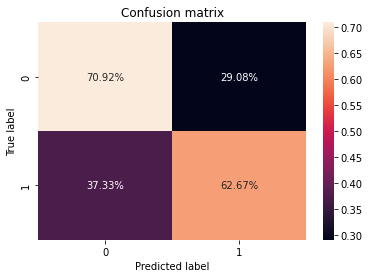

In [91]:
# matrice de confusion

sns.heatmap(confusion_xg, annot=True, fmt='.2%', cbar=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')


####**3. 3 LightGBM**

In [66]:
best_params_lgbm = fmin(fn=lgbm_optimize, space=search_space_xgboost, algo=algorithm, max_evals=10)
best_params_lgbm_bank = fmin(fn=lgbm_optimize_bank, space=search_space_xgboost, algo=algorithm, max_evals=10)

no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
100%|██████████| 10/10 [08:24<00:00, 50.42s/it, best loss: -0.6505378345846254]
no default 6686
default 514
no default 6686
default 514
no default 6686
default 514
no default 6687
default 513
no default 6687
default 513
no default 6686
default 514
no default 6686
default 514
no default 6686
default 

In [67]:
# Meilleurs paramètres lightGBM

best_params_lgbm_eval = space_eval(search_space_xgboost, best_params_lgbm)
best_params_lgbm_eval

{'params': {'colsample_bytree': 0.8132168630511912,
  'learning_rate': 0.43519754549789114,
  'max_depth': 5,
  'min_child_weight': 39.79056816916592,
  'min_split_gain': 0.6036131259427532,
  'n_estimators': 930,
  'num_leaves': 35,
  'reg_alpha': 0.5850750975422979,
  'reg_lambda': 0.06600315224259701,
  'subsample': 0.1635881801762995},
 'sampling': 'smote',
 'threshold': 0.035535073216939946}

In [68]:
# Meilleurs paramètres lightGBM avec bank metric
best_params_lgbm_bank_eval = space_eval(search_space_xgboost, best_params_lgbm_bank)
best_params_lgbm_bank_eval

{'params': {'colsample_bytree': 0.6875508175959324,
  'learning_rate': 0.10480627602863668,
  'max_depth': 3,
  'min_child_weight': 31.841637971270536,
  'min_split_gain': 0.20901660008596734,
  'n_estimators': 931,
  'num_leaves': 37,
  'reg_alpha': 0.5916474828917009,
  'reg_lambda': 0.7356580983762865,
  'subsample': 0.8883705658854852},
 'sampling': 'smote',
 'threshold': 0.03318533095427862}

In [69]:
# Execution du modèle
start = time.time()

if(best_params_lgbm_eval["sampling"] == "resampling"):
  x_fit = X_resampled
  y_fit = y_resampled
else:
  x_fit = x_smote
  y_fit = y_smote

lgbm_model = LGBMClassifier(**best_params_lgbm_eval["params"])
lgbm_model.fit(x_fit, y_fit)
trainend = time.time()
(y_res_lgmb, roc_auc_lgmb, f1_lgmb, precision_lgmb, recall_lgmb, confusion_lgmb, accuracy_lgmb) = predict_and_outputscore(lgbm_model, "LGBMClassifier", X_test, y_test, best_params_lgbm_eval["threshold"])
print("Bank score : " + str(normalized_bank_cost(y_test, transform_with_threshold(y_res_lgmb, 0.5))))
modeles_dict["LGBMClassifier"] = (roc_auc_lgmb, f1_lgmb, precision_lgmb, recall_lgmb, accuracy_lgmb)
confusion_lgmb = confusion_lgmb.astype(np.float)
confusion_lgmb[0] = (confusion_lgmb[0]/confusion_lgmb[0].sum())
confusion_lgmb[1] = (confusion_lgmb[1]/confusion_lgmb[1].sum())

print("Temps total: " + str(time.time() - start))
print("Temps de prédiction: " + str(time.time() - trainend))

LGBMClassifier f1: 0.2134570765661253
LGBMClassifier roc_auc: 0.6390990990990991
LGBMClassifier precision: 0.12921348314606743
LGBMClassifier recall: 0.6133333333333333
LGBMClassifier confusion: [[615 310]
 [ 29  46]]
LGBMClassifier accuracy: 0.661
Bank score : 712.0
Temps total: 16.869178771972656
Temps de prédiction: 0.04287910461425781


Text(0.5, 1.0, 'Confusion matrix')

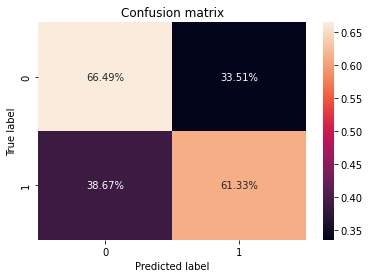

In [81]:
# matrice de confusion

sns.heatmap(confusion_lgmb, annot=True, fmt='.2%', cbar=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

In [120]:
# plotRocAuc(lgbm_model_bank, X_train, y_train)

####**3. 4 LightGBM avec la métrique bank**

In [72]:
start = time.time()

if(best_params_lgbm_eval["sampling"] == "resampling"):
  x_fit = X_resampled
  y_fit = y_resampled
else:
  x_fit = x_smote
  y_fit = y_smote

lgbm_model_bank = LGBMClassifier(**best_params_lgbm_bank_eval["params"])
lgbm_model_bank.fit(x_fit, y_fit)
trainend = time.time()
(y_res_lgmb, roc_auc_lgmb, f1_lgmb, precision_lgmb, recall_lgmb, confusion_lgmb_bank, accuracy_lgmb) = predict_and_outputscore(lgbm_model_bank, "LGBMClassifier", X_test, y_test, best_params_lgbm_bank_eval["threshold"])
print("Bank score : " + str(normalized_bank_cost(y_test, transform_with_threshold(y_res_lgmb, 0.5))))

modeles_dict["LGBMClassifier (Bank)"] = (roc_auc_lgmb, f1_lgmb, precision_lgmb, recall_lgmb, accuracy_lgmb)
confusion_lgmb_bank = confusion_lgmb_bank.astype(np.float)
confusion_lgmb_bank[0] = (confusion_lgmb_bank[0]/confusion_lgmb_bank[0].sum())
confusion_lgmb_bank[1] = (confusion_lgmb_bank[1]/confusion_lgmb_bank[1].sum())

print("Temps total: " + str(time.time() - start))
print("Temps de prédiction: " + str(time.time() - trainend))

LGBMClassifier f1: 0.22832980972515854
LGBMClassifier roc_auc: 0.674054054054054
LGBMClassifier precision: 0.135678391959799
LGBMClassifier recall: 0.72
LGBMClassifier confusion: [[581 344]
 [ 21  54]]
LGBMClassifier accuracy: 0.635
Bank score : 689.0
Temps total: 24.20595908164978
Temps de prédiction: 0.07698631286621094


Text(0.5, 1.0, 'Confusion matrix')

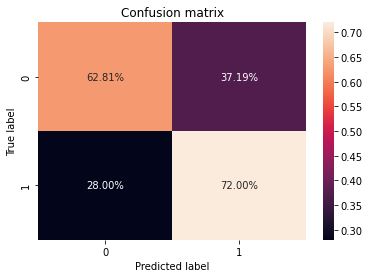

In [82]:
# Matrice de confusion

sns.heatmap(confusion_lgmb_bank, annot=True, fmt='.2%', cbar=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

##**4 Comparaison et sélection du meilleur modèle**

**Comparaison des scores sur les différents modèles**

In [93]:
def plot_dict(dict):
  resultsDataFrame = pd.DataFrame.from_dict(dict, orient='index', columns=["roc_auc", "f1", "precision", "recall", "accuracy"])
  targetDataFrame = resultsDataFrame.reset_index().rename(columns={'index':"Model"}).melt(id_vars='Model', value_vars=['roc_auc', 'f1', 'precision', 'recall', 'accuracy'])
  plt.figure(figsize=(15,5))
  splot = sns.barplot(data=targetDataFrame, hue="variable", x="Model", y="value", palette="husl")
  for p in splot.patches: 
      splot.annotate('{:.2f}'.format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   size=10, 
                   xytext=(0, -12), 
                   textcoords='offset points') 

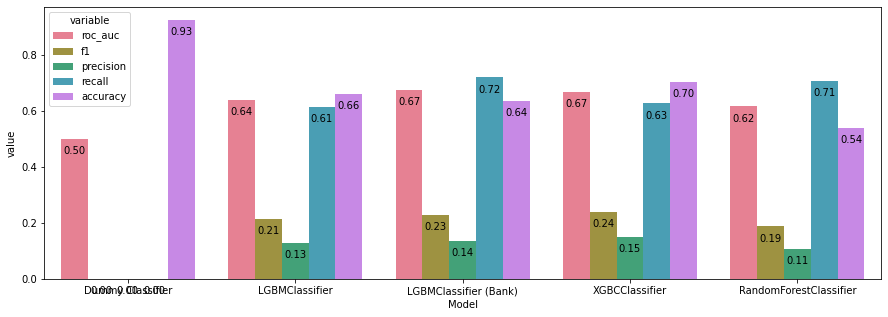

In [94]:
plot_dict(modeles_dict)

In [95]:
modeles_dict

{'Dummy Classifier': (0.5, 0.0, 0.0, 0.0, 0.925),
 'LGBMClassifier': (0.6390990990990991,
  0.2134570765661253,
  0.12921348314606743,
  0.6133333333333333,
  0.661),
 'LGBMClassifier (Bank)': (0.674054054054054,
  0.22832980972515854,
  0.135678391959799,
  0.72,
  0.635),
 'RandomForestClassifier': (0.616036036036036,
  0.18694885361552027,
  0.10772357723577236,
  0.7066666666666667,
  0.539),
 'XGBCClassifier': (0.667927927927928,
  0.2404092071611253,
  0.14873417721518986,
  0.6266666666666667,
  0.703)}

Suite aux modélisations nous pouvons dire que **LightGBM est le meilleur modèle** pour évaluer la solvabilité des clients. Il a des scores comparables à celui de XGBoost, en étant légèrement meilleur, mais il est aussi plus rapide au niveau du temps d'exécution. 


##**V. Importance des features** 

###**1. TOP features** 

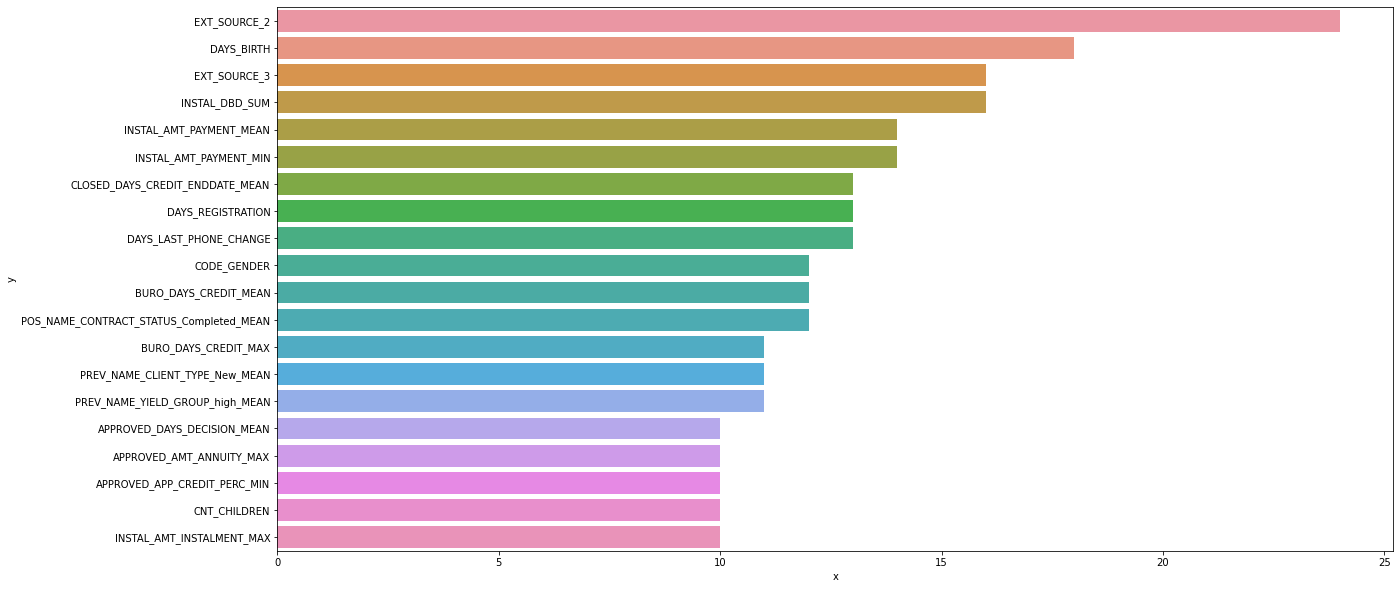

In [96]:
# top 20 paramètres les plus importants pour le modèle LGBM
bestparams = pd.DataFrame({'x':lgbm_model.feature_importances_,'y':X_test.columns})
bestparams.sort_values(by="x",inplace=True, ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x=bestparams.x[:20],y=bestparams.y[:20])

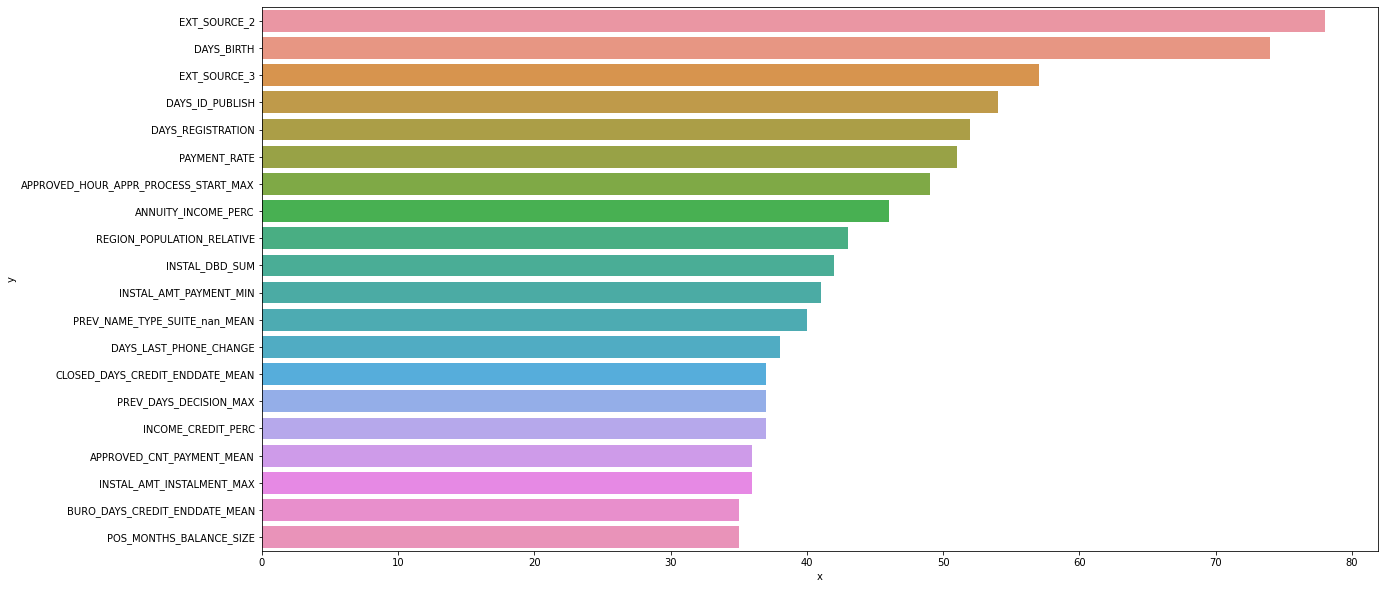

In [97]:
# top 20 paramètres les plus importants pour le modèle LGBM (bank)
bestparams = pd.DataFrame({'x':lgbm_model_bank.feature_importances_,'y':X_test.columns})
bestparams.sort_values(by="x",inplace=True, ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x=bestparams.x[:20],y=bestparams.y[:20])

###**2. TOP features selon SHAP**

https://www.kaggle.com/dansbecker/shap-values
https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach

La mise en œuvre de SHAP repose sur une méthode d’estimation des valeurs de Shapley.
-         1ère étape de calcul des valeurs de Shapley pour un individu en 
particulier : simuler différentes combinaisons de valeurs pour les variables d’entrée

-         2ème étape : Pour chaque combinaison, calculer la différence entre la valeur prédite et la moyenne des prédictions. La valeur de Shapley d’une variable correspond alors à la moyenne de la contribution de sa valeur en fonction des différentes combinaisons. 

In [ ]:
!pip show shap

Name: shap
Version: 0.40.0
Summary: A unified approach to explain the output of any machine learning model.
Home-page: http://github.com/slundberg/shap
Author: Scott Lundberg
Author-email: slund1@cs.washington.edu
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, tqdm, slicer, numba, scikit-learn, packaging, numpy, cloudpickle, pandas
Required-by: 


In [98]:
explainer = shap.TreeExplainer(lgbm_model_bank)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


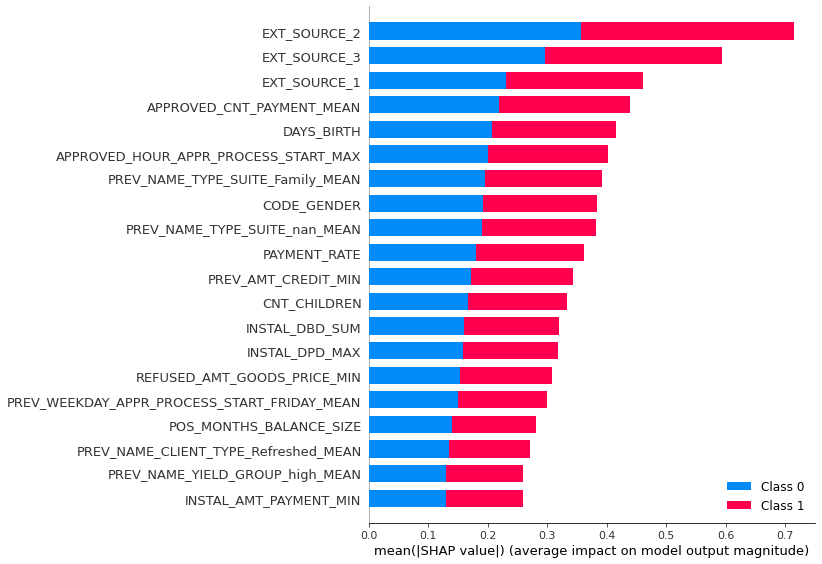

In [99]:
shap.summary_plot(shap_values, X_train.columns)

In [100]:
explainer.expected_value

[-0.8940935826996587, 0.8940935826996587]

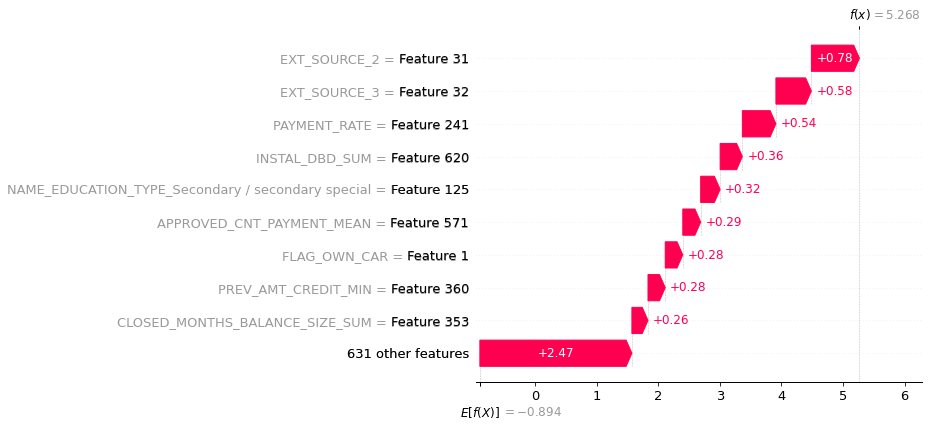

In [101]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][24], X_train.columns)

In [ ]:
pd.DataFrame(shap_values[0][:5000]).to_csv('')

array([[-6.15307439e-02, -6.34198911e-03,  0.00000000e+00, ...,
        -1.55272043e-01,  1.23108385e-01,  2.27684014e-02],
       [ 7.66353382e-02, -2.88216554e-02,  0.00000000e+00, ...,
        -2.77378755e-01,  6.11113478e-02,  5.17680803e-02],
       [ 8.57052711e-02,  7.39196413e-05,  0.00000000e+00, ...,
         9.06420903e-02,  1.13806555e-02, -5.79706046e-02],
       ...,
       [-1.46871470e-01, -3.26197783e-03,  0.00000000e+00, ...,
         2.79790305e-02,  2.10816576e-01,  3.58842225e-02],
       [-2.03805897e-01,  1.06041763e-02,  0.00000000e+00, ...,
         7.20679942e-02,  1.28914823e-01, -3.00658396e-02],
       [ 1.94866910e-01, -6.24564877e-03,  0.00000000e+00, ...,
         1.78872288e-02, -3.48711310e-01, -8.00574020e-03]])

100%|===================| 9963/10000 [02:27<00:00]       

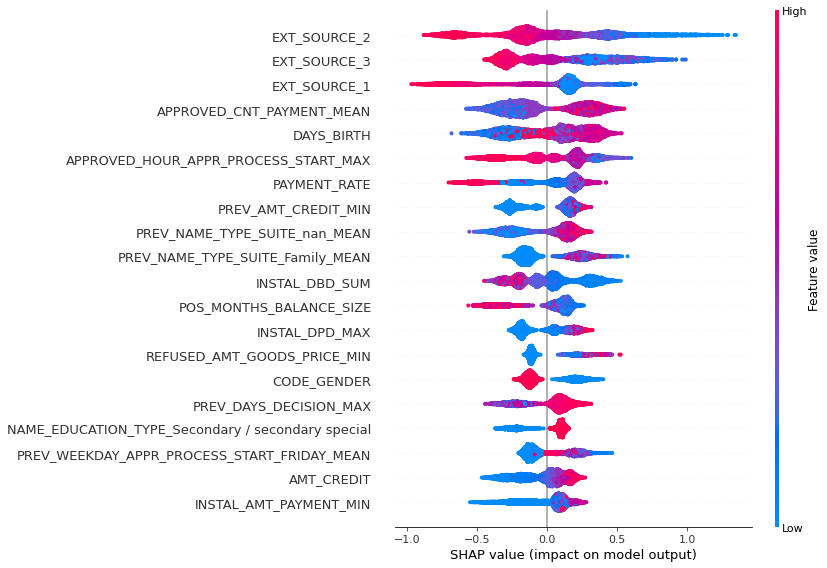

In [118]:
background = X#.sample(1000) 

# background used in explainer defines base value
explainer_t = shap.TreeExplainer(lgbm_model_bank, background, model_output="raw" )

shap_values_t = explainer_t.shap_values(background, check_additivity=False)

#background used in the plot, the points that are visible on the plot

shap.summary_plot(shap_values_t, background, feature_names=background.columns)

In [ ]:
explainer_s = shap.Explainer(lgbm_model_bank)
shap_values_e = explainer_s(X)

In [ ]:
shap_values[0][0]

In [103]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0][5001:5002], X_train.columns)

In [104]:
explainer.expected_value[1]

0.8940935826996587

Les variables (SHAP) ayant le plus de poids dans le modèle LightGBM sont : 
- Ex Source2 :	Normalized score from external data source
- Ex Source3 :	Normalized score from external data source
- Ex Source1 :	Normalized score from external data source

**Sauvegarde du modèle final - banking**

In [105]:
# modelefinal = "modele_final_Lightgbm_bank.sav"
# pickle.dump(lgbm_model_bank, open('/content/drive/MyDrive/modele_final_Lightgbm_bank.sav', 'wb')) erreur modèle not fitted dans l'api (visual)
with open('/content/drive/MyDrive/modele_final_Lightgbm_bank.model', "wb") as f:
        pickle.dump(lgbm_model_bank, f)

In [106]:
# modelefinal = "modele_final_Lightgbm_bank.sav"
# pickle.dump(lgbm_model_bank, open('/content/drive/MyDrive/modele_final_Lightgbm_bank.sav', 'wb')) erreur modèle not fitted dans l'api (visual)
with open('/content/drive/MyDrive/explainer.model', "wb") as f:
        pickle.dump(explainer, f)

In [107]:
with open('/content/drive/MyDrive/shap_values.shap', "wb") as f:
        pickle.dump(shap_values[0][:5000], f)

In [ ]:
pd.DataFrame(shap_values[0][:5000]).to_csv('/content/drive/MyDrive/shap_values_0.shap')
pd.DataFrame(shap_values[1][:5000]).to_csv('/content/drive/MyDrive/shap_values_1.shap')

In [108]:
pd.DataFrame(shap_values[0][:5000])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639
0,0.276314,0.006675,0.170058,0.162986,0.012103,0.075902,0.174288,-0.004007,0.080116,-0.299514,-0.032349,0.023765,0.160013,0.014309,0.0,0.0,-0.014862,0.0,0.138433,0.009861,0.082680,0.115892,0.019370,0.052741,0.0,0.0,0.0,0.003139,0.148716,0.250735,-0.101460,0.010733,0.278379,0.042172,0.001316,0.035071,-0.004057,-0.004818,0.001177,0.000666,...,0.010482,0.016130,0.0,-0.034065,0.0,0.0,0.0,-0.014534,0.0,0.0,-0.108431,0.0,0.0,0.024295,-0.007778,0.159477,0.056162,0.046492,-0.016033,0.007726,0.100811,0.0,0.000909,-0.056630,-0.030183,0.116767,-0.004826,-0.000233,0.064763,0.096004,-0.055937,-0.005764,-0.040633,0.000231,-0.086107,0.058508,0.017112,0.097440,0.038269,-0.070918
1,0.241202,0.001591,0.225645,0.194352,0.047283,0.275756,0.139760,0.023277,0.172010,0.149951,-0.002521,-0.157228,-0.074719,0.024528,0.0,0.0,0.232202,0.0,0.100767,0.007900,-0.001167,0.097327,0.023890,0.095028,0.0,0.0,0.0,0.001201,-0.006584,-0.006281,-0.059380,0.287496,-0.090228,-0.025009,-0.004150,-0.013827,0.056294,-0.004818,-0.015955,-0.013877,...,0.010482,0.006791,0.0,-0.028890,0.0,0.0,0.0,-0.052515,0.0,0.0,0.013626,0.0,0.0,0.076960,0.266954,-0.181803,-0.048487,-0.161685,-0.064587,-0.036739,0.183161,0.0,0.001099,0.003035,-0.012006,-0.011409,-0.025598,0.080392,-0.003852,-0.103954,-0.050008,0.006116,0.403898,-0.010565,-0.067240,0.045727,0.007115,0.042031,0.018256,-0.066825
2,0.196923,0.032100,0.015609,0.166844,0.161664,-0.019733,-0.113413,-0.002623,-0.156899,-0.088961,-0.018599,0.010310,-0.060729,0.013371,0.0,0.0,-0.009911,0.0,0.198533,0.010083,0.093581,0.104417,0.063940,0.025003,0.0,0.0,0.0,0.003139,-0.021190,-0.016575,0.963151,0.768456,0.112285,-0.094755,0.000907,-0.011703,-0.004621,0.030767,0.002623,0.053147,...,0.004847,0.015395,0.0,0.044695,0.0,0.0,0.0,-0.008328,0.0,0.0,0.019047,0.0,0.0,-0.050388,0.051571,-0.043591,-0.005863,0.041970,0.014565,-0.042998,-0.246647,0.0,0.004902,0.012123,-0.016551,0.080695,0.001449,0.008208,0.044072,0.152482,-0.039105,-0.006940,-0.087932,0.033866,-0.058533,-0.049266,0.042144,0.004568,0.011284,0.010094
3,0.245943,0.001438,0.027448,0.170019,0.169493,-0.253587,-0.093552,-0.018872,-0.273009,0.357959,0.187304,0.366989,0.122586,0.007855,0.0,0.0,-0.014862,0.0,0.127688,0.009124,0.051512,0.119993,0.098269,0.036952,0.0,0.0,0.0,0.001701,-0.031362,-0.019743,-0.027106,0.902774,0.533067,0.027797,0.003282,-0.002137,-0.002810,-0.004818,0.002623,-0.000173,...,0.004926,0.013254,0.0,0.014456,0.0,0.0,0.0,0.029092,0.0,0.0,0.019856,0.0,0.0,0.025386,0.041789,-0.141722,-0.020462,-0.057717,0.052722,-0.004785,0.185621,0.0,-0.006677,-0.014092,0.003664,-0.031479,0.036352,-0.081320,-0.027131,-0.097025,-0.006745,0.005551,-0.017179,-0.015758,0.092185,0.017387,-0.119045,0.033723,0.037283,-0.024208
4,-0.102797,0.015530,0.113718,0.144519,-0.046248,0.097196,-0.077125,0.073478,-0.011685,0.178891,0.024410,0.294200,-0.108808,0.029969,0.0,0.0,0.246543,0.0,0.064474,0.006517,0.034925,0.056015,0.032052,0.077793,0.0,0.0,0.0,-0.020557,0.143056,-0.014711,-0.457483,0.189287,-0.195705,0.019744,0.000907,0.011916,-0.004621,-0.004818,0.002623,0.000666,...,0.004926,0.025867,0.0,0.015665,0.0,0.0,0.0,0.036422,0.0,0.0,0.022966,0.0,0.0,-0.023107,0.292219,0.206453,0.027291,0.038842,-0.037316,0.000432,-0.040054,0.0,-0.002466,-0.004991,0.018468,0.177075,0.003092,0.016116,-0.002193,0.089922,-0.047252,-0.018739,-0.044381,0.021070,-0.084644,-0.064316,0.049893,-0.017942,0.001754,-0.022080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.049969,